Optimization of jack pine budworm instar weighting (w) based on frass (excrement) and population proportion from BIoSIM. BioSIM utlizes the information of weather for each location to simulate the emergence and population proportion for each year. Here, we integrated field-collected frass data and feeding population proportion (percent) based on spring feeding phenology. Feeding population of jack pine budworm starts from L2 instar which emerge in the spring and start to consume pollen and new leaves to L7 instar. In this study, we used 12 plots (JP03, JP04, JP05, JP09, JP11, JP13, JP16, JP26, JP27, JP201, JP202, JP203) that had captured the feeding phenology (start,peak, and end) for instar weighting (w) optimization.

Optimization process includes: 
    I. fit distribution curve to field-collected frass data 
    II. initialize the optimizaiton of instar weighting (w)
    III. apply following two constriants during the optimziaiton: 
        a. w >= 0 && w < 1. 
        b.sum of weighting (w) must be one 

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import leastsq
from scipy.integrate import quad
from scipy.stats import norm, skewnorm, linregress, cauchy,kendalltau
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit,minimize
from sklearn.metrics import auc

# magic function to view graphs in notebook, instead of pop-up windows
%matplotlib inline

In [2]:
# distribution function used to fit field-collected frass data
def norm_fn(x, coeff, loc, scale):
    y_fit = coeff * norm.pdf(x, loc, scale)
    return y_fit

def norm_residuals(p, x, y):
    integral = quad(norm_fn, x[0]-0.5, x[-1]+0.5, args=(p[0], p[1], p[2]))[0]
    penalty = np.abs(np.sum(y) - integral) * 1E6
    y_fit = norm_fn(x, p[0], p[1], p[2])
    residuals = y - y_fit - penalty
    return residuals

# gaussian distribution function
def gaussian_fn(x, coeff, loc, scale):
    y_fit = coeff * np.exp(-1 * (x - loc)**2 / scale)
    return y_fit

def gaussian_residuals(p, x, y):
    target = np.sum(y)
    integral = quad(gaussian_fn, x[0]-0.5, x[-1]+0.5, args=(p[0], p[1], p[2]))[0]
    penalty = np.abs(target - integral) * 1E6
    y_fit = gaussian_fn(x, p[0], p[1], p[2])
    residuals = y - y_fit - penalty
    return residuals


In [3]:
## Use optimization function to find the optimal instar weighting (w)

# create model that includes frass weighting (w)
model = lambda w, X: w[0] * X[:,0] + w[1] * X[:,1] + w[2] * X[:,2] + w[3] * X[:,3] + w[4] * X[:,4] + w[5]*X[:,5]

# goal is to minimize the residual sum of squares:
obj = lambda w, Y, X: np.sum(np.abs(Y-model(w, X))**2)

In [4]:
# Constraints for instar weighting (w): 

# First constraints i.e. w >= 0
bnds = [(0, 0.01), (0, 0.01), (0.01, 0.01),(0.01,0.2), (0.3, 1), (0.1, 1)]

# second constraint of frass weighting(w) i.e. sum(b)=1
def constraint1(w):
    return w[0]+w[1]+w[2]+w[3]+w[4]+w[5]- 1

def constraint2(w):
    target = 1
    c = np.array([2,3,4,5,6,7])
    return (target - auc(c,w))

con1 = {'type': 'ineq', 'fun': constraint1}
con2 = {'type': 'eq', 'fun': constraint2}
cons = ([con1,con2])

In [ ]:
df = pd.read.csv('filename.csv')

In [ ]:
## Fit distribution function to frass data
fittedFrass = []

for j in PlotIDs:
    ndf = df[(df["PlotID"] == j)]
    doy = np.array(ndf['DOY'])
    avgFrass = np.array(ndf['frassRate'])
    
    # now get x-days
    x = range(1,(np.size(avgFrass) +1))
    # fit normal distribution function by using curve_fit function
    frass_opt,f_cov = curve_fit(norm_fn,x,avgFrass)
    coeff_best, loc_best, scale_best = frass_opt
    print('Distribution parameters of plot %s' %j)
    print('coeff = %.3f, loc = %.3f, scale = %.3f' % (coeff_best, loc_best, scale_best))
    
    # fit frass data
    fitted_Frass = norm_fn(x, coeff_best, loc_best, scale_best)
    fittedFrass.append(fitted_Frass)
     
    # calculate RMSE and R-square of fitted frass data
    y_residual =  avgFrass - fitted_Frass               
    mae = np.mean(np.abs(y_residual))      
    rmse = np.sqrt(np.mean(y_residual**2))  
    sse = np.sum(y_residual**2)             
    sst = np.sum((avgFrass - np.mean(avgFrass))**2)       
    rsq = 1.0 - (sse / sst) 
    
    #
    print('RMSE: %.3f' %rmse)
    print('R-square: %.3f' %rsq)

## append fitted frass data to dataframe
fittedFrass_cp = np.array(fittedFrass)
fittedFrass_cp =np.hstack(fittedFrass_cp)

df['fitted_Frass'] = fittedFrass_cp

In [ ]:
## Global optimization of frass weight by using fitted frass data to instar data from BioSim outputs.
## Leave-one-out cross validation (LOOCV) i.e. one plot from list of plots in PlotIDs were removed  
## and used minimize function to estimate frass weights
## rmse and r-square for both model and test data were calculated. 

# Initial instar weighting (w)
xinit = np.array([0.001,0.001,0.001,0.1,0.1,0.1])
instars = np.array([2,3,4,5,6,7])

# weighting (w) values for each instars:
L2 = []
L3 = []
L4 = []
L5 = []
L6 = []
L7 = []

## Cross-validation results:
Model_RMSE = []
Model_Rsq = []
Model_Cor = []

Test_RMSE = []
Test_Rsq = []

### Optimizated instar weighting (w)

for j in PlotIDs:
    ndf = df[(df["PlotID"] != j)]
    
    # population data:
    popX = ndf[['L2','L3','L4','L5','L6','L7']].values
    
    # frass data:
    fitY = np.array(ndf['fitted_Frass']) 
    
    #optimization function:
    res = minimize(obj, args=(fitY,popX),method='SLSQP', x0=xinit, bounds=bnds, constraints=cons)
    wPop = res.x
    w1,w2,w3,w4,w5,w6 = wPop
    
    # add 'w' for each instar
    L2.append(w1)
    L3.append(w2)
    L4.append(w3)
    L5.append(w4)
    L6.append(w5)
    L7.append(w6)
    
    print('Plot remove: %s' %j)
    print('Weighting are:')
    print(wPop)
        
    # estimate the weighted larvae
    weightedLarvae = model(wPop,popX)
    
    # calculate the model RMSE and R-square:
    y_residual = fitY - weightedLarvae                
    mae = np.mean(np.abs(y_residual))      
    m_rmse = np.sqrt(np.mean(y_residual**2))  
    sse = np.sum(y_residual**2)             
    sst = np.sum((fitY - np.mean(fitY))**2)       
    m_rsq = 1.0 - (sse / sst)
    cor = kendalltau(weightedLarvae, fitY)[0] 
    print('Model RMSE: %.3f' %m_rmse)
    print('Model R-square: %.3f' %m_rsq)
    print('Correlation between fitted Instar and fitted Frass: %.3f' %cor)
    
    ## append Model CV results
    Model_RMSE.append(m_rmse)
    Model_Rsq.append(m_rsq)
    Model_Cor.append(cor)
    
    # calculate the test data RMSE and R-square:
    testDF = df[(df["PlotID"] == j)]
    testX = testDF[['L2','L3','L4','L5','L6','L7']].values
    testY = np.array(testDF['fitted_Frass'])
    weighted_testY = model(wPop,testX)
    
    test_residual = testY - weighted_testY               
    mae = np.mean(np.abs(test_residual))      
    rmse = np.sqrt(np.mean(test_residual**2))  
    sse = np.sum(test_residual**2)             
    sst = np.sum((testY - np.mean(testY))**2)       
    rsq = 1.0 - (sse / sst)
    print('Test RMSE: %.3f' %rmse)
    print('Test R-square: %.3f' %rsq)
    
    ## append Test CV result
    Test_RMSE.append(rmse)
    Test_Rsq.append(rsq)
    
    
    
##### Instar Weighting (w) for each instar
### save dataframe as .csv file
beta_df = np.column_stack((PlotIDs,L2,L3,L4,L5,L6,L7))     
beta_df = pd.DataFrame(data=beta_df,columns=['PlotID','L2','L3','L4','L5','L6','L7'])
beta_df.to_csv('Larvae_weighting_filename.csv')

#### Cross-validation result
CV_df = np.column_stack((PlotIDs,Model_RMSE, Model_Rsq, Model_Cor, Test_RMSE, Test_Rsq))  
CV_df = pd.DataFrame(data= CV_df,columns=['PlotID','Model_RMSE','Model_Rsq','Model_Cor','Test_RMSE','Test_Rsq'])
CV_df.to_csv('CrossValidation_Results_filename.csv')


In [5]:
sdf = pd.read_csv('Budworm_Frass_BioSIM_Optimization_Example.csv')
print(sdf.head(5))

  PlotID  DOY  week  frassRate  Overwintering       L2        L3        L4  \
0     JP  152     1   1.646799              0  1.66221  17.60822  68.24011   
1     JP  153     1   1.646799              0  1.20325  13.36262  66.34715   
2     JP  154     1   1.646799              0  0.84804  10.26984  62.34846   
3     JP  155     1   1.646799              0  0.49747   8.67313  54.36080   
4     JP  156     1   1.646799              0  0.33457   5.26738  44.90834   

         L5       L6       L7  Pupae  Adults  fitted_Frass  
0  12.48351  0.00595  0.00000    0.0     0.0      0.052432  
1  19.05554  0.03143  0.00000    0.0     0.0      0.094722  
2  26.37868  0.15497  0.00001    0.0     0.0      0.166297  
3  35.65311  0.81542  0.00007    0.0     0.0      0.283727  
4  46.83795  2.65134  0.00042    0.0     0.0      0.470438  


Gaussian Distribution Function Parameters for Average Instar
[ 44.71038375  20.80966531 156.10705576]


<Figure size 4800x4400 with 0 Axes>

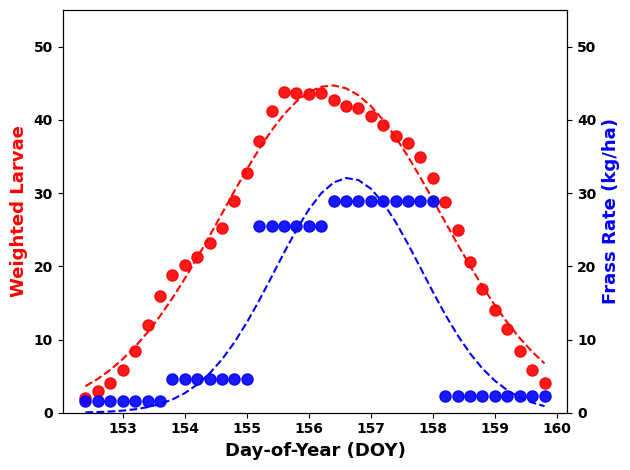

In [6]:
import warnings
warnings.filterwarnings('ignore')

doy = np.array(sdf['DOY'])
avgFrass = np.array(sdf['frassRate'])
    
# now get x-days
x = np.arange(1,(np.size(doy)+1),1)

# fit frass data by using previous parameters
#fitted_frass= np.array(iFrass['fittedFrass'])
# distribution parameters can be changed based on visual inspection of the plot
#fitted_frass = norm_fn(x,439,22,5.8)
fitted_Frass = np.array(sdf['fitted_Frass'])

# instar data from BioSim
xmat = sdf[['L2','L3','L4','L5','L6','L7']]

# frass weight for each instar
# start with previous guess values
#beta = np.array([0.001,0.001,0.001,0.1,0.67,0.23])
beta = np.array([0.001,0.001,0.001,0.15,0.51,0.39])

# calculate average instar 
weightedLarvae = xmat.dot(beta)
    
# fit average instar data to distribution:
coeff_init = 2
loc_init = 7
scale_init = 1
        
poptL, pcovL = leastsq(func=gaussian_residuals, x0=(coeff_init,loc_init, scale_init), args=(x, weightedLarvae))
coeff_bestL, loc_bestL, scale_bestL = poptL
print('Gaussian Distribution Function Parameters for Average Instar')
print(poptL)
     
# fit the average instar data based on above parameters
fitL = gaussian_fn(x, coeff_bestL, loc_bestL, scale_bestL) 

## other plot:
fig = plt.figure(figsize = (6,5.5), dpi = 800)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Day-of-Year (DOY)', size =13, weight = 'bold')
ax1.set_xticklabels(doy, fontsize=10, weight = 'bold')
ax1.set_ylabel('Weighted Larvae',color='red',size=13, weight = 'bold')
ax1.plot(doy, fitL,'r--',linewidth =1.5)
ax1.plot(doy, weightedLarvae,'ro', label = 'Average Instar',markersize =8,alpha =0.9)

ax1.tick_params(axis='y')
ax1.set_ylim(0,55)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Frass Rate (kg/ha)',color='blue',weight ='bold',size =13)  
ax2.plot(doy, avgFrass, 'bo',label='Frass Rate',markersize =8,alpha =0.9)
ax2.plot(doy, fitted_Frass, 'b--', label='Fitted Frass',linewidth =1.5)

plt.setp(ax1.get_yticklabels(),fontsize=10,weight = 'bold')
plt.setp(ax2.get_yticklabels(),fontsize=10,weight = 'bold')

ax2.tick_params(axis='y')
ax2.set_ylim(0,55)

fig.tight_layout() 

plt.show()